# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import loguniform
from scipy.stats import uniform

from sklearn.datasets import fetch_california_housing
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, RidgeCV, Ridge, SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, ShuffleSplit, validation_curve, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#Common Setup

In [2]:
# set up random seed:

np.random.seed(306)

In [3]:
# use shufflesplit as cv with 10 splits and set 20% examples aside as test set
cv= ShuffleSplit(n_splits= 10, test_size = 0.2, random_state = 42)

#  Load the Data

In [4]:
features, labels = fetch_california_housing(as_frame= True, return_X_y = True)

# Train-Test Split 
com_train_features, test_features, com_train_labels, test_labels = train_test_split(features, labels, random_state = 42)

# train >> train + dev
train_features, dev_features, train_labels, dev_labels = train_test_split(com_train_features, com_train_labels, random_state = 42)

# Linear Regression with Normal Equation

In [10]:
lin_reg_pipeline = Pipeline([('feature_scaling', StandardScaler()),
                             ('lin_reg', LinearRegression())])

lin_reg_cv_results = cross_validate(lin_reg_pipeline, 
                                    com_train_features, 
                                    com_train_labels,
                                    cv = cv,
                                    scoring = 'neg_mean_absolute_error',
                                    return_train_score = True,
                                    return_estimator = True)

lin_reg_train_error = -1 * lin_reg_cv_results['train_score']
lin_reg_test_error = -1 * lin_reg_cv_results['test_score']

print(f'Mean Absolute Error of LR model on TRAIN SET {lin_reg_train_error.mean():.3f} +/- {lin_reg_test_error.std():.3f}')
print(f'Mean Absolute Error of LR model on TEST SET {lin_reg_test_error.mean():.3f} +/- {lin_reg_test_error.std():.3f}')

Mean Absolute Error of LR model on TRAIN SET 0.530 +/- 0.008
Mean Absolute Error of LR model on TEST SET 0.527 +/- 0.008


# Linear Regression with SGD

In [12]:
sgd_reg_pipeline = Pipeline([('feature_scaling', StandardScaler()),
                             ('sgd_reg', SGDRegressor(max_iter = np.ceil(1e6/com_train_features.shape[0]),
                                                      early_stopping = True,
                                                      eta0 = 1e-4,
                                                      learning_rate = 'constant',
                                                      tol = 1e-5,
                                                      validation_fraction = 0.1,
                                                      n_iter_no_change = 5,
                                                      average = 10,
                                                      random_state = 42))])
sgd_reg_cv_results = cross_validate(sgd_reg_pipeline,
                                    com_train_features,
                                    com_train_labels,
                                    cv=cv,
                                    scoring = "neg_mean_absolute_error",
                                    return_train_score = True,
                                    return_estimator = True)


sgd_train_error = -1 * sgd_reg_cv_results['train_score']
sgd_test_error = -1 * sgd_reg_cv_results['test_score']

print(f'Mean Absolute Error of SGD regression model on TRAIN SET {sgd_train_error.mean()} +/- {sgd_train_error.std()}')
print(f'Mean Absolute Error of SGD regression model on TEST SET {sgd_test_error.mean()} +/- {sgd_test_error.std()}')

Mean Absolute Error of SGD regression model on TRAIN SET 0.5640399853222634 +/- 0.02266704205287487
Mean Absolute Error of SGD regression model on TEST SET 0.5607392935103552 +/- 0.025296964206753057


## Poynomial Regression

In [14]:
# We will train a polynomial model with degree 2 and later we will use validation_curve to find
# out right degree to use for polynomial models.

# PolynomialFeatures transforms the features to the user specified degrees (here it is 2). We
# perform feature scaling on the transformed features before using them for training the
# regression model.

poly_reg_pipeline = Pipeline([('poly', PolynomialFeatures(degree = 2)),
                              ('feature_scaling', StandardScaler()),
                              ('lin_reg', LinearRegression())])


poly_reg_cv_results = cross_validate(poly_reg_pipeline,
                                     com_train_features,
                                     com_train_labels,
                                     cv = cv,
                                     scoring = 'neg_mean_absolute_error',
                                     return_train_score = True,
                                     return_estimator = True)

poly_reg_train_error = -1 * poly_reg_cv_results['train_score']
poly_reg_test_error = -1 * poly_reg_cv_results['test_score']

print(f'Mean Absolute Error of Linear Regression Model on the train set {poly_reg_train_error.mean() : 3f} +/- {poly_reg_train_error.std():3f}')
print(f'Mean Absolute Error of Linear Regression Model on the test set {poly_reg_test_error.mean() : 3f} +/- {poly_reg_test_error.std():3f}')


Mean Absolute Error of Linear Regression Model on the train set  0.460964 +/- 0.002977
Mean Absolute Error of Linear Regression Model on the test set  0.485446 +/- 0.030312


In [24]:
# Alternatively we can set interaction_only = True

poly_reg_pipeline = Pipeline([('poly', PolynomialFeatures(degree = 2, 
                                                          interaction_only= True)),
                              ('feature_scaling', StandardScaler()),
                              ('lin_reg', LinearRegression())])


poly_reg_cv_results = cross_validate(poly_reg_pipeline,
                                     com_train_features,
                                     com_train_labels,
                                     cv = cv,
                                     scoring = 'neg_mean_absolute_error',
                                     return_train_score = True,
                                     return_estimator = True)

poly_reg_train_error = -1 * poly_reg_cv_results['train_score']
poly_reg_test_error = -1 * poly_reg_cv_results['test_score']

print(f'Mean Absolute Error of Linear Regression Model on the train set {poly_reg_train_error.mean():.3f} +/- {poly_reg_train_error.std():.3f}')
print(f'Mean Absolute Error of Linear Regression Model on the test set {poly_reg_test_error.mean():.3f} +/- {poly_reg_test_error.std():.3f}')


Mean Absolute Error of Linear Regression Model on the train set 0.478 +/- 0.003
Mean Absolute Error of Linear Regression Model on the test set 0.497 +/- 0.024


Lets figure out which degree polynomial is better suited for the regression problem at our hand. For that we will use `validation_curve`, which will be considered as manual hyperparameter tuning. 


Here we specify list of values that we want to try for polynomial degree and specify it as a parameter in `validation curve`

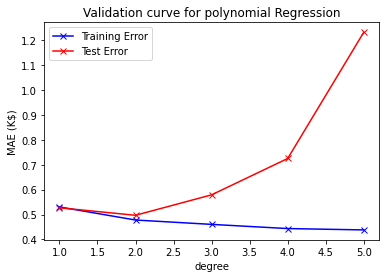

In [25]:
degree = [1,2,3,4,5]

train_scores, test_scores = validation_curve(
    poly_reg_pipeline, com_train_features, com_train_labels, param_name = 'poly__degree',
    param_range = degree, cv = cv, scoring = 'neg_mean_absolute_error',
    n_jobs = 2
)

train_errors, test_errors = - train_scores, -test_scores
plt.plot(degree, train_errors.mean(axis = 1), 'b-x', label = 'Training Error')
plt.plot(degree, test_errors.mean(axis = 1), 'r-x', label = 'Test Error')
plt.legend()

plt.xlabel('degree')
plt.ylabel('MAE (K$)')
_ = plt.title('Validation curve for polynomial Regression')

We would select the degree where MAE for train is least in this case 2

# Ridge regression

The polynomial models have a tendency to overfit - if we use higher order polynomial features.
We will use Ridge regression - which penalizes for excessive model complexity in the
polynomial regression by adding a regularization term. Here we specify the regularization rate
alpha as 0.5 and train the regression model. Later we will launch hyperparameter search for
the right value of alpha such that it leads to the least cross validation errors.

In [26]:
ridge_reg_pipeline = Pipeline([('poly', PolynomialFeatures(degree = 2)),
                               ('feature_scaling', StandardScaler()),
                               ('ridge', Ridge(alpha=0.5))])

ridge_reg_cv_results = cross_validate(ridge_reg_pipeline,
                                      com_train_features,
                                      com_train_labels,
                                      cv=cv,
                                      scoring="neg_mean_absolute_error",
                                      return_train_score=True,
                                      return_estimator=True)


ridge_reg_train_error = -1 * ridge_reg_cv_results['train_score']
ridge_reg_test_error = -1 * ridge_reg_cv_results['test_score']

print(f"Mean absolute error of ridge regression model (alpha=0.5) on the train set:\n"
f"{ridge_reg_train_error.mean():.3f} +/- {ridge_reg_train_error.std():.3f}")
print(f"Mean absolute error of ridge regression model (alpha=0.5) on the test set:\n"
f"{ridge_reg_test_error.mean():.3f} +/- {ridge_reg_test_error.std():.3f}")

Mean absolute error of ridge regression model (alpha=0.5) on the train set:
0.481 +/- 0.003
Mean absolute error of ridge regression model (alpha=0.5) on the test set:
0.487 +/- 0.006


# HPT For Ridge Regularization Rate

In [27]:
alpha_list = np.logspace(-4, 0, num=20)
ridge_reg_pipeline = Pipeline([("poly", PolynomialFeatures(degree=2)),
                               ("feature_scaling", StandardScaler()),
                               ("ridge_cv", RidgeCV(alphas=alpha_list,
                                                    cv=cv,
                                                    scoring="neg_mean_absolute_error"))])

ridge_reg_cv_results = ridge_reg_pipeline.fit(com_train_features, com_train_labels)

In [28]:
print ("The score with the best alpha is:",
f"{ridge_reg_cv_results[-1].best_score_:.3f}")
print ("The error with the best alpha is:",
f"{-ridge_reg_cv_results[-1].best_score_:.3f}")

The score with the best alpha is: -0.473
The error with the best alpha is: 0.473


In [29]:
print ("The best value for alpha:", ridge_reg_cv_results[-1].alpha_)

The best value for alpha: 0.007847599703514606


# RidgeCV with CrossValidation

In [31]:
alpha_list = np.logspace(-4, 0, num=20)
ridge_reg_pipeline = Pipeline([("poly", PolynomialFeatures(degree=2)),
                               ("feature_scaling", StandardScaler()),
                               ("ridge_cv", RidgeCV(alphas=alpha_list,store_cv_values=True))])

ridge_reg_cv_results = cross_validate(ridge_reg_pipeline,
                                      com_train_features,
                                      com_train_labels,
                                      cv=cv,
                                      scoring="neg_mean_absolute_error",
                                      return_train_score=True,
                                      return_estimator=True)

ridge_reg_train_error = -1 * ridge_reg_cv_results['train_score']
ridge_reg_test_error = -1 * ridge_reg_cv_results['test_score']

In [32]:
print(f"Mean absolute error of ridge regression model on the train set:\n"
f"{ridge_reg_train_error.mean():.3f} +/- {ridge_reg_train_error.std():.3f}")
print(f"Mean absolute error of ridge regression model on the test set:\n"
f"{ridge_reg_test_error.mean():.3f} +/- {ridge_reg_test_error.std():.3f}")

Mean absolute error of ridge regression model on the train set:
0.470 +/- 0.011
Mean absolute error of ridge regression model on the test set:
0.474 +/- 0.011


Let's look at the mean of mean absolute errors at different values of regularization rate across
different cross validation folds.

In [33]:
mse_alphas = [est[-1].cv_values_.mean(axis=0) for est in ridge_reg_cv_results["estimator"]]
cv_alphas = pd.DataFrame(mse_alphas, columns=alpha_list)
cv_alphas

,0.000100,0.000162,0.000264,0.000428,0.000695,0.001129,0.001833,0.002976,0.004833,0.007848,0.012743,0.020691,0.033598,0.054556,0.088587,0.143845,0.233572,0.379269,0.615848,1.000000
0,79.825105,83.556979,89.052274,96.713331,106.577419,117.958587,129.309233,138.553544,143.696595,143.239843,136.323827,122.943609,104.328753,82.970054,61.840053,43.298869,28.559398,17.803633,10.526486,5.909713
1,14.065799,13.742714,13.245802,12.504952,11.450787,10.048351,8.345884,6.505474,4.765508,3.333758,2.295126,1.610844,1.183945,0.919624,0.750990,0.641272,0.577008,0.556458,0.575055,0.616682
2,5.267710,5.272331,5.279626,5.290956,5.308105,5.333104,5.367714,5.412616,5.466685,5.526801,5.588436,5.647108,5.700570,5.751087,5.806722,5.879665,5.978467,6.094229,6.190664,6.210415
3,5.853085,5.867043,5.888945,5.922643,5.972982,6.045051,6.142429,6.264704,6.405584,6.553176,6.692444,6.808469,6.889793,6.931979,6.940661,6.931633,6.923902,6.924670,6.915607,6.852967
4,8.134646,7.993974,7.781172,7.471108,7.042443,6.489075,5.830605,5.110992,4.379774,3.666586,2.970194,2.275449,1.595598,1.021163,0.731173,0.912456,1.609059,2.646320,3.729320,4.609697
5,66.100008,60.047159,52.002193,42.279138,31.879141,22.232981,14.513912,9.100108,5.651189,3.553748,2.267632,1.438728,0.884846,0.552525,0.464962,0.651161,1.080903,1.657819,2.268932,2.827886
6,2.309882,2.253722,2.168544,2.044094,1.871808,1.650275,1.391207,1.120910,0.873056,0.675781,0.543603,0.482411,0.504610,0.643451,0.952959,1.480223,2.215475,3.063332,3.875894,4.520391
7,19.019937,20.494095,22.742542,26.033396,30.548208,36.182667,42.368884,48.126041,52.384040,54.327657,53.538865,50.004599,44.134732,36.750467,28.898463,21.529074,15.270441,10.392246,6.862006,4.445108
8,4.351827,4.345297,4.335085,4.319448,4.296236,4.263277,4.219299,4.165380,4.106281,4.050251,4.006641,3.983150,3.985501,4.019862,4.095335,4.222623,4.405521,4.627181,4.842507,4.987779
9,3.963850,3.952362,3.934504,3.907436,3.867958,3.813571,3.744526,3.666285,3.590431,3.532157,3.505531,3.520803,3.586362,3.713344,3.917635,4.213494,4.596544,5.025147,5.419899,5.688782


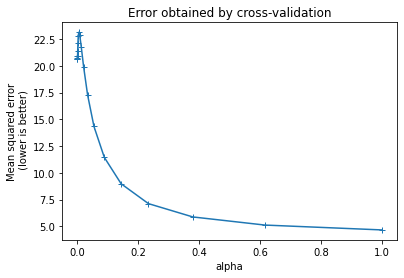

In [34]:
cv_alphas.mean(axis=0).plot(marker="+")
plt.ylabel("Mean squared error\n (lower is better)")
plt.xlabel("alpha")
_ = plt.title("Error obtained by cross-validation")

In [35]:
best_alphas = [est[-1].alpha_ for est in ridge_reg_cv_results["estimator"]]
best_alphas

[1.0,
 0.3792690190732246,
 0.0001,
 0.0001,
 0.08858667904100823,
 0.08858667904100823,
 0.0206913808111479,
 1.0,
 0.0206913808111479,
 0.012742749857031334]

The optimal regularization strength is not necessarily the same on all cross-validation
iterations. But since we expect each cross-validation resampling to stem from the same data
distribution, it is common practice to use the average value of the best alpha found on different
cross-validation folds as our final estimate for the tuned alpha.

In [36]:
print(f"The mean optimal alpha leading to the best generalization performance is:\n"
f"{np.mean(best_alphas):.2f} +/- {np.std(best_alphas):.2f}")

The mean optimal alpha leading to the best generalization performance is:
0.26 +/- 0.38


# Ridge HPT through GridSearchCV

In [37]:
ridge_grid_pipeline = Pipeline([("poly", PolynomialFeatures(degree=2)),
                                ("feature_scaling", StandardScaler()),
                                ("ridge", Ridge())])

param_grid = {'poly__degree': (1, 2, 3),'ridge__alpha': np.logspace(-4, 0, num=20)}
ridge_grid_search = GridSearchCV(ridge_grid_pipeline,
                                 param_grid=param_grid,
                                 n_jobs=2,
                                 cv=cv,
                                 scoring="neg_mean_absolute_error",
                                 return_train_score=True)
ridge_grid_search.fit(com_train_features, com_train_labels)

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size=0.2, train_size=None),
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('feature_scaling', StandardScaler()),
                                       ('ridge', Ridge())]),
             n_jobs=2,
             param_grid={'poly__degree': (1, 2, 3),
                         'ridge__alpha': array([1.00000000e-04, 1.62377674e-04, 2.63665090e-04, 4.28133240e-04,
       6.95192796e-04, 1.12883789e-03, 1.83298071e-03, 2.97635144e-03,
       4.83293024e-03, 7.84759970e-03, 1.27427499e-02, 2.06913808e-02,
       3.35981829e-02, 5.45559478e-02, 8.85866790e-02, 1.43844989e-01,
       2.33572147e-01, 3.79269019e-01, 6.15848211e-01, 1.00000000e+00])},
             return_train_score=True, scoring='neg_mean_absolute_error')

ridge_grid_search.best_index_ gives us the index of the best parameter in the list.

In [38]:
mean_train_error = -1 * ridge_grid_search.cv_results_['mean_train_score'][ridge_grid_search.best_index_]
mean_test_error = -1 * ridge_grid_search.cv_results_['mean_test_score'][ridge_grid_search.best_index_]
std_train_error = ridge_grid_search.cv_results_['std_train_score'][ridge_grid_search.best_index_]
std_test_error = ridge_grid_search.cv_results_['std_train_score'][ridge_grid_search.best_index_]

In [39]:
print(f"Best Mean absolute error of polynomial ridge regression model on the train set:\n"
f"{mean_train_error:.3f} +/- {std_train_error:.3f}")
print(f"Mean absolute error of polynomial ridge regression model on the test set:\n"
f"{mean_test_error:.3f} +/- {std_test_error:.3f}")

Best Mean absolute error of polynomial ridge regression model on the train set:
0.463 +/- 0.004
Mean absolute error of polynomial ridge regression model on the test set:
0.474 +/- 0.004


In [40]:
print ("Mean cross validated score of the best estimator is: ", ridge_grid_search.best_score_)
print ("Mean cross validated error of the best estimator is: ", -ridge_grid_search.best_score_)

Mean cross validated score of the best estimator is:  -0.4738651176991914
Mean cross validated error of the best estimator is:  0.4738651176991914


Note that this is same as RidgeCV that we carried out earlier.

In [41]:
print ("The best parameter value is:", ridge_grid_search.best_params_)

The best parameter value is: {'poly__degree': 2, 'ridge__alpha': 0.007847599703514606}


# LASSO REGULARIZATION

## Baseline model with fixed learning rate

In [42]:
lasso_reg_pipeline = Pipeline([("poly", PolynomialFeatures(degree=2)),
                               ("feature_scaling", StandardScaler()),
                               ("lasso", Lasso(alpha=0.01))])
lasso_reg_cv_results = cross_validate(lasso_reg_pipeline,
                                      com_train_features,
                                      com_train_labels,
                                      cv=cv,
                                      scoring="neg_mean_absolute_error",
                                      return_train_score=True,
                                      return_estimator=True)
lasso_reg_train_error = -1 * lasso_reg_cv_results['train_score']
lasso_reg_test_error = -1 * lasso_reg_cv_results['test_score']

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.986e+01, tolerance: 1.654e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.109e+01, tolerance: 1.669e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.849e+01, tolerance: 1.658e+00

In [43]:
print(f"Mean absolute error of linear regression model on the train set:\n"
f"{lasso_reg_train_error.mean():.3f} +/- {ridge_reg_train_error.std():.3f}")
print(f"Mean absolute error of linear regression model on the test set:\n"
f"{lasso_reg_test_error.mean():.3f} +/- {ridge_reg_test_error.std():.3f}")

Mean absolute error of linear regression model on the train set:
0.529 +/- 0.011
Mean absolute error of linear regression model on the test set:
0.528 +/- 0.011


# HPT for lasso regularization rate

## With cross validation

In [46]:
alpha_list = np.logspace(-6, 0, num=20)
lasso_reg_pipeline = Pipeline([("poly", PolynomialFeatures(degree=2)),
                               ("feature_scaling", StandardScaler()),
                               ("lasso_cv", LassoCV(alphas=alpha_list, cv=cv))])

lasso_reg_cv_results = cross_validate(lasso_reg_pipeline,
                                      com_train_features,
                                      com_train_labels,
                                      cv=cv,
                                      scoring="neg_mean_absolute_error",
                                      return_train_score=True,
                                      return_estimator=True)
lasso_reg_train_error = -1 * lasso_reg_cv_results['train_score']
lasso_reg_test_error = -1 * lasso_reg_cv_results['test_score']

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4040323869976419, tolerance: 1.3364869834102626
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.9423024900243036, tolerance: 1.3364869834102626
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.597153668672945, tolerance: 1.3364869834102626
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWa

In [47]:
print(f"Mean absolute error of linear regression model on the train set:\n"
f"{lasso_reg_train_error.mean():.3f} +/- {lasso_reg_train_error.std():.3f}")
print(f"Mean absolute error of linear regression model on the test set:\n"
f"{lasso_reg_test_error.mean():.3f} +/- {lasso_reg_test_error.std():.3f}")

Mean absolute error of linear regression model on the train set:
0.524 +/- 0.015
Mean absolute error of linear regression model on the test set:
0.524 +/- 0.013


In [45]:
best_alphas = [est[-1].alpha_ for est in lasso_reg_cv_results["estimator"]]
best_alphas

[0.012742749857031322,
 0.012742749857031322,
 0.00615848211066026,
 0.00615848211066026,
 0.00615848211066026,
 1e-06,
 0.012742749857031322,
 0.0003359818286283781,
 0.00615848211066026,
 0.026366508987303555]

In [48]:
print(f"The mean optimal alpha leading to the best generalization performance is:\n"
f"{np.mean(best_alphas):.2f} +/- {np.std(best_alphas):.2f}")

The mean optimal alpha leading to the best generalization performance is:
0.01 +/- 0.01


In [49]:
lasso_reg_pipeline = Pipeline([("poly", PolynomialFeatures(degree=2)),
                               ("feature_scaling", StandardScaler()),
                               ("lasso", Lasso(alpha=0.01))])
lasso_reg_pipeline.fit(com_train_features, com_train_labels)
train_error = mean_absolute_error(com_train_labels,

lasso_reg_pipeline.predict(com_train_features))
print(f"Mean absolute error of Lasso CV model on the train set:", train_error)

Mean absolute error of Lasso CV model on the train set: 0.5291330037868303


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.759e+01, tolerance: 2.066e+00
  model = cd_fast.enet_coordinate_descent(


# with GridSearchCV

In [51]:
lasso_grid_pipeline = Pipeline([("poly", PolynomialFeatures()),
                                ("feature_scaling", StandardScaler()),
                                ("lasso", Lasso())])

param_grid = {'poly__degree': (1, 2, 3),
              'lasso__alpha': np.logspace(-4, 0, num=20)}

lasso_grid_search = GridSearchCV(lasso_grid_pipeline,
                                 param_grid=param_grid,
                                 n_jobs=2,
                                 cv=cv,
                                 scoring="neg_mean_absolute_error",
                                 return_train_score=True)
lasso_grid_search.fit(com_train_features, com_train_labels)

KeyboardInterrupt: ignored

In [ ]:
mean_train_error = -1 * lasso_grid_search.cv_results_['mean_train_score'][lasso_grid_search.best_index_]
mean_test_error = -1 * lasso_grid_search.cv_results_['mean_test_score'][lasso_grid_search.best_index_]
std_train_error = lasso_grid_search.cv_results_['std_train_score'][lasso_grid_search.best_index_]
std_test_error = lasso_grid_search.cv_results_['std_train_score'][lasso_grid_search.best_index_]

In [ ]:
print(f"Best Mean absolute error of polynomial ridge regression model on the train set:\n"
f"{mean_train_error:.3f} +/- {std_train_error:.3f}")
print(f"Mean absolute error of polynomial ridge regression model on the test set:\n"
f"{mean_test_error:.3f} +/- {std_test_error:.3f}")

In [ ]:
print ("Mean cross validated score of the best estimator is: ", lasso_grid_search.best_score_)

In [ ]:
print ("The best parameter value is:", lasso_grid_search.best_params_)

# SGD: Regularization and HPT

We can also perform regularization with SGD. SGDRegressor has many hyperparameters that
require careful tuning to achieve the same performance as with LinearRegression

In [52]:
poly_sgd_pipeline = Pipeline([("poly", PolynomialFeatures()),
                              ("feature_scaling", StandardScaler()),
                              ("sgd_reg", SGDRegressor(penalty='elasticnet',random_state=42))])

poly_sgd_cv_results = cross_validate(poly_sgd_pipeline,
                                     com_train_features,
                                     com_train_labels,
                                     cv=cv,
                                     scoring="neg_mean_absolute_error",
                                     return_train_score=True,
                                     return_estimator=True)
poly_sgd_train_error = -1 * poly_sgd_cv_results['train_score']
poly_sgd_test_error = -1 * poly_sgd_cv_results['test_score']

In [53]:
print(f"Mean absolute error of linear regression model on the train set:\n"
f"{poly_sgd_train_error.mean():.3f} +/- {poly_sgd_train_error.std():.3f}")
print(f"Mean absolute error of linear regression model on the test set:\n"
f"{poly_sgd_test_error.mean():.3f} +/- {poly_sgd_test_error.std():.3f}")

Mean absolute error of linear regression model on the train set:
10824283052.546 +/- 4423288211.832
Mean absolute error of linear regression model on the test set:
10946788540.250 +/- 5396536227.703


Let's search for the best set of parameters for polynomial + SGD pipeline with
RandomizedSearchCV .

Remember in RandomizedSearchCV , we need to specify distributions for
hyperparameters.

In [55]:
class uniform_int:
  """Integer valued version of the uniform distribution"""
  
  def __init__(self, a, b):
    self._distribution = uniform(a, b)
  
  def rvs(self, *args, **kwargs):
    """Random variable sample"""
    return self._distribution.rvs(*args, **kwargs).astype(int)

Let's specify RandomizedSearchCV set up.

In [56]:
param_distributions = {'poly__degree': [1, 2, 3], 
                       'sgd_reg__learning_rate': ['constant', 'adaptive', 'invscaling'],
                       'sgd_reg__l1_ratio': uniform(0, 1),
                       'sgd_reg__eta0': loguniform(1e-5, 1),
                       'sgd_reg__power_t': uniform(0, 1)}
poly_sgd_random_search = RandomizedSearchCV(poly_sgd_pipeline,
                                            param_distributions=param_distributions,
                                            n_iter=10,
                                            cv=cv,
                                            verbose=1, 
                                            scoring='neg_mean_absolute_error')
poly_sgd_random_search.fit(com_train_features, com_train_labels)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_

RandomizedSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size=0.2, train_size=None),
                   estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                             ('feature_scaling',
                                              StandardScaler()),
                                             ('sgd_reg',
                                              SGDRegressor(penalty='elasticnet',
                                                           random_state=42))]),
                   param_distributions={'poly__degree': [1, 2, 3],
                                        'sgd_reg__eta0': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7b412b9a90>,
                                        'sgd_reg__l1_ratio': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7b412b9520>,
                                        'sgd_reg__learning_rate': ['constant',
                                                                   'a

In [57]:
# the best score
poly_sgd_random_search.best_score_

-0.5380096909337503

In [58]:
# the best set of parameters
poly_sgd_random_search.best_params_

{'poly__degree': 2,
 'sgd_reg__eta0': 0.09791299852127132,
 'sgd_reg__l1_ratio': 0.5203784939670418,
 'sgd_reg__learning_rate': 'invscaling',
 'sgd_reg__power_t': 0.8066987770187414}

In [59]:
# And the best estimator can be accessed with best_estimator_ member variable.

# Comparison of weight vectors

In [60]:
feature_names = poly_reg_cv_results["estimator"][0][0].get_feature_names_out(input_features=train_features.columns)
feature_names

array(['1', 'MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population',
       'AveOccup', 'Latitude', 'Longitude', 'MedInc HouseAge',
       'MedInc AveRooms', 'MedInc AveBedrms', 'MedInc Population',
       'MedInc AveOccup', 'MedInc Latitude', 'MedInc Longitude',
       'HouseAge AveRooms', 'HouseAge AveBedrms', 'HouseAge Population',
       'HouseAge AveOccup', 'HouseAge Latitude', 'HouseAge Longitude',
       'AveRooms AveBedrms', 'AveRooms Population', 'AveRooms AveOccup',
       'AveRooms Latitude', 'AveRooms Longitude', 'AveBedrms Population',
       'AveBedrms AveOccup', 'AveBedrms Latitude', 'AveBedrms Longitude',
       'Population AveOccup', 'Population Latitude',
       'Population Longitude', 'AveOccup Latitude', 'AveOccup Longitude',
       'Latitude Longitude'], dtype=object)

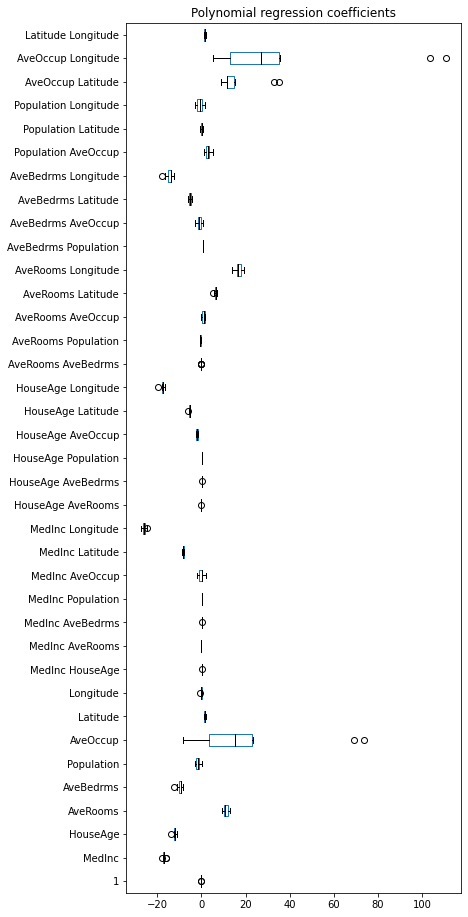

In [62]:
coefs = [est[-1].coef_ for est in poly_reg_cv_results["estimator"]]
weights_polynomial_regression = pd.DataFrame(coefs, columns=feature_names)
color = {"whiskers": "black", "medians": "black", "caps": "black"}
weights_polynomial_regression.plot.box(color=color, vert=False, figsize=(6, 16))
_ = plt.title("Polynomial regression coefficients")

In [63]:
feature_names = ridge_reg_cv_results["estimator"][0][0].get_feature_names_out(
input_features=train_features.columns)
feature_names

array(['1', 'MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population',
       'AveOccup', 'Latitude', 'Longitude', 'MedInc^2', 'MedInc HouseAge',
       'MedInc AveRooms', 'MedInc AveBedrms', 'MedInc Population',
       'MedInc AveOccup', 'MedInc Latitude', 'MedInc Longitude',
       'HouseAge^2', 'HouseAge AveRooms', 'HouseAge AveBedrms',
       'HouseAge Population', 'HouseAge AveOccup', 'HouseAge Latitude',
       'HouseAge Longitude', 'AveRooms^2', 'AveRooms AveBedrms',
       'AveRooms Population', 'AveRooms AveOccup', 'AveRooms Latitude',
       'AveRooms Longitude', 'AveBedrms^2', 'AveBedrms Population',
       'AveBedrms AveOccup', 'AveBedrms Latitude', 'AveBedrms Longitude',
       'Population^2', 'Population AveOccup', 'Population Latitude',
       'Population Longitude', 'AveOccup^2', 'AveOccup Latitude',
       'AveOccup Longitude', 'Latitude^2', 'Latitude Longitude',
       'Longitude^2'], dtype=object)

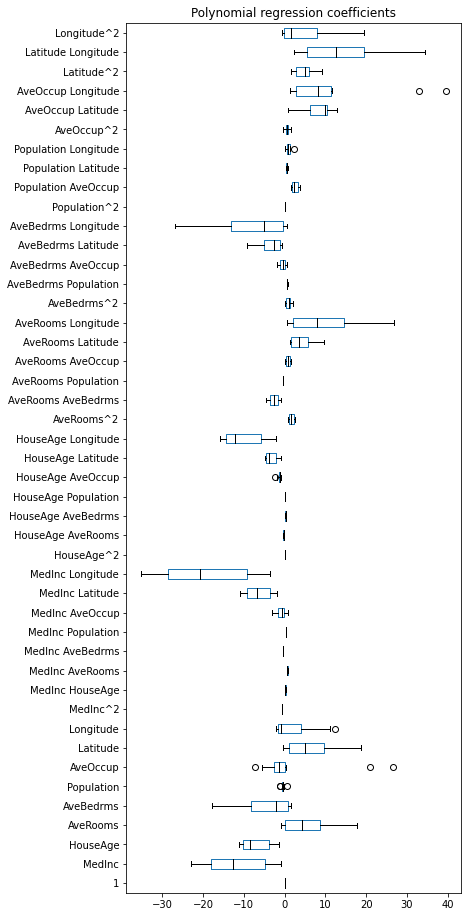

In [64]:
coefs = [est[-1].coef_ for est in ridge_reg_cv_results["estimator"]]
weights_ridge_regression = pd.DataFrame(coefs, columns=feature_names)

color = {"whiskers": "black", "medians": "black", "caps": "black"}
weights_ridge_regression.plot.box(color=color, vert=False, figsize=(6, 16))
_ = plt.title("Polynomial regression coefficients")

# Performance on the test set

## Baseline

In [65]:
baseline_model_median = DummyRegressor(strategy='median')
baseline_model_median.fit(train_features, train_labels)
mean_absolute_percentage_error(test_labels,baseline_model_median.predict(test_features))

0.5348927548151625

## Linear regression with normal equation

In [66]:
mean_absolute_percentage_error(test_labels,lin_reg_cv_results['estimator'][0].predict(test_features))

0.32120472175482906

In [67]:
mean_absolute_percentage_error(test_labels,poly_sgd_random_search.best_estimator_.predict(test_features))

0.31260954539418107

## Polynomial Regression

In [68]:
poly_reg_pipeline.fit(com_train_features, com_train_labels)
mean_absolute_percentage_error(test_labels,poly_reg_pipeline.predict(test_features))

0.28199759082657233

## Ridge regression

In [69]:
mean_absolute_percentage_error(test_labels, ridge_grid_search.best_estimator_.predict(test_features))

0.2711033645141509

## Lasso regression

In [73]:
mean_absolute_percentage_error(test_labels,
                               lasso_grid_search.best_estimator_.predict(test_features))

# since lasso did not complete. The cells were stopped in between

AttributeError: ignored